In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as sc
import plotly.graph_objects as go
from IPython.display import Image

%matplotlib inline

### Загрузка файлов

In [2]:
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
studentAssessment = pd.read_csv('studentAssessment.csv')
studentRegistration = pd.read_csv('studentRegistration.csv')

### assessments
этот файл содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).
- `code_module` — идентификационный код предмета.
- `code_presentation` — семестр (Идентификационный код).
- `id_assessment` — тест (Идентификационный номер ассессмента).
- `assessment_type` — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).
- `date` — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).
- `weight` — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

In [3]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


### courses
файл содержит список предметов по семестрам.
- `code_module` — предмет (идентификационный код).
- `code_presentation` — семестр (идентификационный код).
- `module_presentation_length` — продолжительность семестра в днях.

In [4]:
courses

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240
5,BBB,2014B,234
6,CCC,2014J,269
7,CCC,2014B,241
8,DDD,2013J,261
9,DDD,2014J,262


### studentAssessment
этот файл содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.

- `id_assessment` — тест (идентификационный номер).

- `id_student` — идентификационный номер студента.

- `date_submitted` — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.

- `is_banked` — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).

- `score` — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

In [5]:
studentAssessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [6]:
studentAssessment.query('score.isna() == True').id_assessment

215        1752
937        1754
2364       1760
3358      14984
3914      14984
          ...  
148929    34903
159251    37415
166390    37427
169725    37435
170103    37435
Name: id_assessment, Length: 173, dtype: int64

### studentRegistration
этот файл содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.

- `code_module` — предмет (идентификационный код).
- `code_presentation` — семестр (идентификационный код)
- `id_student` — идентификационный номер студента.
- `date_registration` — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).
- `date_unregistration` — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

In [7]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [8]:
studentRegistration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

## <span style="color:LightSlateGray">1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене).</span>

Проведем небольшой анализ данных для того, чтобы разобраться получше какими данными мы оперируем и для того, чтобы на основе этих данных в конечном итоге сделать выводы

####  <span style="color:DarkGreen">1. Во-первых - нас интересуют лишь прошедшие курс ученики, а это мы можем узнать следующим образом: </span>
   - Поскольку поле `date_unregistration` в таблице `studentRegistration` у студентов, окончивших курс, остается пустым, то мы находим лишь тех студентов, которые сохранились в бд без отмены регистрации. 
   - Ищем в таблице `studentAssessment` значения id_student схожие со списком предобработанных значений из таблицы `studentRegistration`

In [9]:
register_students = studentRegistration.query('date_unregistration.isna() == True').id_student.unique()
register_students = studentAssessment[studentAssessment['id_student'].isin(register_students)]
register_students

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0
...,...,...,...,...,...
173907,37443,527538,227,0,60.0
173908,37443,534672,229,0,100.0
173909,37443,546286,215,0,80.0
173910,37443,546724,230,0,100.0


#### <span style="color:DarkGreen">2. Во-вторых, в условии задачи сказано, что успешная сдача курса - это зачет по курсу на экзамене, а значит нашу предыдущую таблицу необходимо сопоставить с таблицей `assessments`, в которой мы отберем только экзамен. А также отсеем учеников, которые не сдали экзамен, то есть набрали меньше 40 баллов. </span>

In [10]:
graduate_students = assessments.query('assessment_type == "Exam"') \
                               .merge(register_students, on = 'id_assessment') \
                               .query('score >= 40')
graduate_students.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
1,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0
2,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0
3,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0
4,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0
5,CCC,2014B,24290,Exam,NaN,100.0,560494,230,0,92.0


Заодно проверим нет ли в наших данных ошибки, поскольку если бы студент не зарегистрировался на курс и прошел его, то мы бы получили данных больше, чем если бы не выполняли первый пункт:

In [11]:
all_students = assessments.merge(register_students, on = 'id_assessment')

In [12]:
graduate_students.shape == all_students.query('assessment_type == "Exam" & score >= 40').shape

True

С данными все в порядке, мы получили одинаковое количество строк

#### <span style="color:DarkGreen">3. Посмотрим по каким предметам студенты сдавали экзамены за все семестры</span>

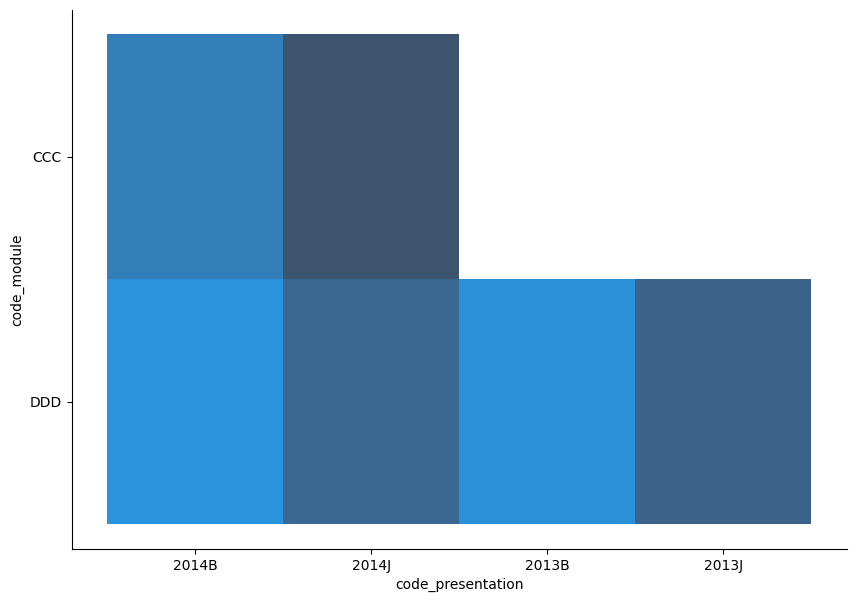

In [13]:
plt.figure(figsize= (10,7))
sns.histplot(data = graduate_students, y = 'code_module', x = 'code_presentation')
sns.despine()

#### <span style="color:DarkGreen">4. Проверим количество студентов обучающихся на сессиях</span>

In [14]:
count_all_std = all_students.groupby('code_presentation', as_index = False).agg({'id_student':'nunique'})
count_all_std

,code_presentation,id_student
0,2013B,3270
1,2013J,6289
2,2014B,4919
3,2014J,7199


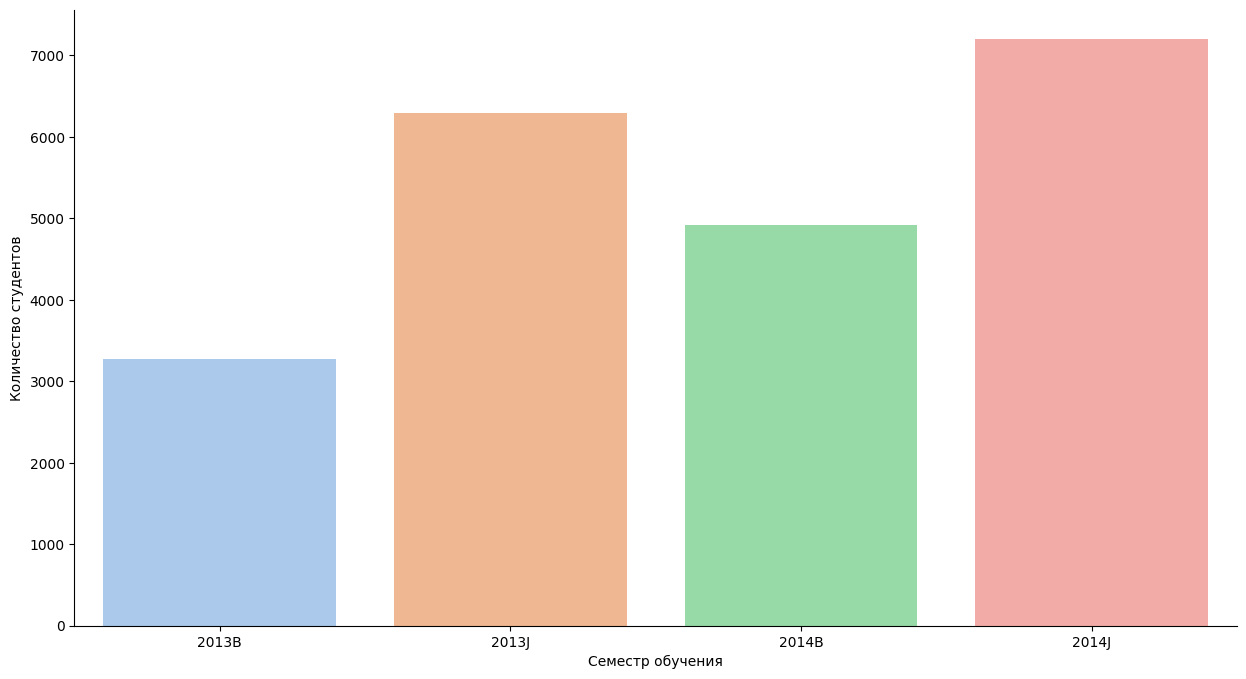

In [15]:
plt.figure(figsize= (15,8))
ax = sns.barplot(data = count_all_std, x = 'code_presentation', y = 'id_student',
                palette = 'pastel')
ax.set_xlabel('Семестр обучения')
ax.set_ylabel('Количество студентов')
sns.despine()

#### <span style="color:DarkGreen">5. Посмотрим поближе на данные в таблице `courses` и таблице `assesment`, в которой мы отобрали только экзамены, сделав из нее таблицу `graduate_students`</span>

In [16]:
lenght_courses = courses.query('code_module == "CCC" or code_module == "DDD"').copy()
lenght_courses['year_and_module'] =  lenght_courses.code_presentation + ' / ' + lenght_courses.code_module
lenght_courses

,code_module,code_presentation,module_presentation_length,year_and_module
6,CCC,2014J,269,2014J / CCC
7,CCC,2014B,241,2014B / CCC
8,DDD,2013J,261,2013J / DDD
9,DDD,2014J,262,2014J / DDD
10,DDD,2013B,240,2013B / DDD
11,DDD,2014B,241,2014B / DDD


Для соединения двух таблиц по двум значениям сделаю конкатенацию двух столбцов, по которой в дальнейшем и проведу `merge`

In [17]:
graduate_students = graduate_students.sort_values('date_submitted')
graduate_students['year_and_module'] = graduate_students.code_presentation + ' / ' + graduate_students.code_module
graduate_students

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,year_and_module
2116,DDD,2013B,25340,Exam,240.0,100.0,477451,229,0,56.0,2013B / DDD
2080,DDD,2013B,25340,Exam,240.0,100.0,441302,229,0,76.0,2013B / DDD
2294,DDD,2013B,25340,Exam,240.0,100.0,546826,229,0,56.0,2013B / DDD
2325,DDD,2013B,25340,Exam,240.0,100.0,550604,229,0,62.0,2013B / DDD
2085,DDD,2013B,25340,Exam,240.0,100.0,443215,229,0,44.0,2013B / DDD
...,...,...,...,...,...,...,...,...,...,...,...
1706,CCC,2014J,24299,Exam,NaN,100.0,352637,259,0,96.0,2014J / CCC
1143,CCC,2014J,24299,Exam,NaN,100.0,634824,259,0,42.0,2014J / CCC
738,CCC,2014B,24290,Exam,NaN,100.0,555008,266,0,56.0,2014B / CCC
4319,DDD,2014J,25368,Exam,NaN,100.0,2341830,279,0,49.0,2014J / DDD


In [18]:
diff_dates = graduate_students[['date_submitted', 'year_and_module']] \
                                            .merge(lenght_courses, on = 'year_and_module')
diff_dates['diff_btw_days'] = diff_dates.module_presentation_length - \
                                            diff_dates.date_submitted
diff_dates.sort_values('diff_btw_days')

,date_submitted,year_and_module,code_module,code_presentation,module_presentation_length,diff_btw_days
1167,266,2014B / CCC,CCC,2014B,241,-25
3372,279,2014J / DDD,DDD,2014J,262,-17
4391,285,2014J / CCC,CCC,2014J,269,-16
1652,251,2014B / DDD,DDD,2014B,241,-10
1166,242,2014B / CCC,CCC,2014B,241,-1
...,...,...,...,...,...,...
3471,243,2014J / CCC,CCC,2014J,269,26
3470,243,2014J / CCC,CCC,2014J,269,26
3469,243,2014J / CCC,CCC,2014J,269,26
3466,243,2014J / CCC,CCC,2014J,269,26


<span style="color:Tomato">**на основе полученных данных из пунктов 3, 4 и 5 - делаем выводы:**</span>

1. Из пункта <span style="color:Tomato">**3**</span> делаем вывод - В 2013 году экзамен проводился лишь по предмету - DDD, а в 2014 году добавился экзамен - CCC, а значит скорее всего программа обучения расширялась и школа/обучающая платформа, росла, о чем также свидетельствует рост учеников с каждым семестром.
2. На основе данных из <span style="color:Tomato">**4**</span> пункта, предполагаю, что буквенные обозначения B и J обозначают летнюю и зимнюю сессию соответственно. Мое предположение основано на том, что летом люди скорее всего будут брать обучения или курсы меньше, чем зимой. На графике в 4 пункте можно увидеть, что в целом с каждым годом приток студентов растет, но в сессию B студентов меньше, чем в предыдущем году в сессию J.
3. Из пункта <span style="color:Tomato">**5**</span> делаем выводы: 
    - Колонка `module_presentation_length` в таблице `courses` означает продолжительность семестра в днях
    - При подробном рассмотрении таблицы `graduate_students` в которую мы отобрали только экзамены, которые сдавали студенты, мы обнаружим колонку `date_submitted` со значениями, которые очень близки к значениям `module_presentation_length`. 
    - Произведя объединение данных на основе года и предмета по этим таблицам мы находим, истинную разницу в днях между продолжительностью курса и датой сдачи экзамена учениками. 
    - При условии, что успешная сдача - это зачет по **курсу** на экзамене, а длительность курса(длительность до сдачи экзамена в днях) практически равна длительности семестра - делаем вывод: <span style="color:Tomato">курсом является предмет, внутри семестра</span>, а семестр начинается дважды в год и продолжается на протяжении всего учебного года, за исключением каникул, которые примерно равны:  $$≈365 - module\_presentation\_length$$
    - Также на основе разницы между `module_presentation_length` и `date_submitted` можно сделать вывод, что есть ученики, которые сдавали экзамен с запозданием, а значит школа/платформа предоставляла возможность закрывать экзамены после окончания семестра. 

In [19]:
graduate_students.drop(columns = 'year_and_module')

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
2116,DDD,2013B,25340,Exam,240.0,100.0,477451,229,0,56.0
2080,DDD,2013B,25340,Exam,240.0,100.0,441302,229,0,76.0
2294,DDD,2013B,25340,Exam,240.0,100.0,546826,229,0,56.0
2325,DDD,2013B,25340,Exam,240.0,100.0,550604,229,0,62.0
2085,DDD,2013B,25340,Exam,240.0,100.0,443215,229,0,44.0
...,...,...,...,...,...,...,...,...,...,...
1706,CCC,2014J,24299,Exam,NaN,100.0,352637,259,0,96.0
1143,CCC,2014J,24299,Exam,NaN,100.0,634824,259,0,42.0
738,CCC,2014B,24290,Exam,NaN,100.0,555008,266,0,56.0
4319,DDD,2014J,25368,Exam,NaN,100.0,2341830,279,0,49.0


#### <span style="color:DarkGreen">6. Теперь, после анализа данных, перейдем к самой задаче</span>

В отобранной таблице успешно сдавших экзамен студентов добавляю единицу, означающую успешную сдачу одного экзамена и на основе этих данных сгруппирую по студентам и отберу тех, кто сдал курс успешно лишь один раз

In [20]:
graduate_students['success_passed'] = 1

In [21]:
succ_passed_only_one = graduate_students.groupby('id_student') \
                                        .agg({'success_passed':'sum'}) \
                                        .query('success_passed == 1')
succ_passed_only_one.count()

success_passed    3802
dtype: int64

### <span style="color:SteelBlue">Ответ:</span>
Успешно сдали курс только один раз <span style="color:SteelBlue">**3802**</span> студента

## <span style="color:LightSlateGray">2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*.</span>

*<span style="color:Tomato">завершаемость</span> = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

#### <span style="color:DarkGreen">1. Для того, чтобы посмотреть на завершаемость курсов, необходимо отобрать из таблицы `all_students` все экзамены</span>

In [22]:
all_exams = all_students.query('assessment_type == "Exam"')
all_exams

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
49968,CCC,2014B,24290,Exam,NaN,100.0,558914,230,0,32.0
49969,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0
49970,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0
49971,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0
49972,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0
...,...,...,...,...,...,...,...,...,...,...
89420,DDD,2014J,25368,Exam,NaN,100.0,652680,243,0,91.0
89421,DDD,2014J,25368,Exam,NaN,100.0,652732,249,0,47.0
89422,DDD,2014J,25368,Exam,NaN,100.0,652965,242,0,87.0
89423,DDD,2014J,25368,Exam,NaN,100.0,653051,242,0,27.0


#### <span style="color:DarkGreen">2. А теперь сравнить таблицу `all_exams` с таблицей `graduate_students`</span>

In [23]:
success_exams = graduate_students.groupby(['code_presentation', 'code_module'], as_index = False) \
                  .agg(students = ('id_assessment','count'))  \
                  .sort_values('students', ascending = False)
success_exams

,code_presentation,code_module,students
4,2014J,CCC,1019
1,2013J,DDD,878
5,2014J,DDD,842
2,2014B,CCC,664
0,2013B,DDD,504
3,2014B,DDD,485


In [24]:
grouped_all_exams = all_exams.groupby(['code_presentation', 'code_module'], as_index = False) \
                  .agg(students = ('id_assessment','count'))  \
                  .sort_values('students', ascending = False)
grouped_all_exams

,code_presentation,code_module,students
4,2014J,CCC,1168
1,2013J,DDD,967
5,2014J,DDD,950
2,2014B,CCC,747
0,2013B,DDD,602
3,2014B,DDD,524


#### <span style="color:DarkGreen">3. Найдем процент завершаемости экзамменов</span>

In [25]:
success_exams['peace_of_success'] = success_exams.students / grouped_all_exams.students
success_exams = success_exams.sort_values('peace_of_success')
success_exams

,code_presentation,code_module,students,peace_of_success
0,2013B,DDD,504,0.837209
4,2014J,CCC,1019,0.872432
5,2014J,DDD,842,0.886316
2,2014B,CCC,664,0.888889
1,2013J,DDD,878,0.907963
3,2014B,DDD,485,0.925573


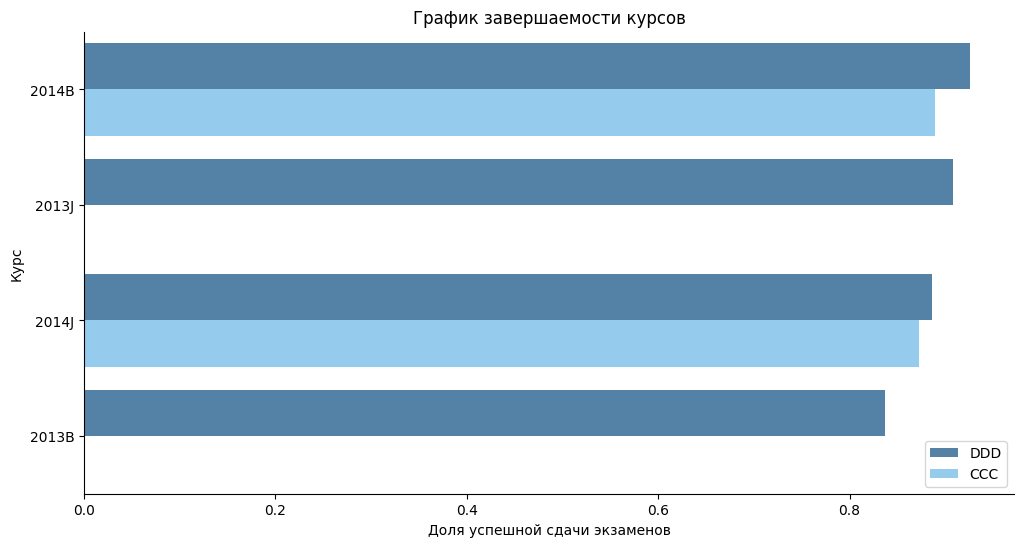

In [26]:
plt.figure(figsize = (12,6))
ends_plot = sns.barplot(data = success_exams, x = 'peace_of_success', y = 'code_presentation', 
                 hue = 'code_module', 
                 order = ['2014B', '2013J', '2014J', '2013B'],
                 orient = "h", 
                 palette = ('SteelBlue', 'LightSkyBlue'))
ends_plot.set_title('График завершаемости курсов', fontsize='large')
ends_plot.set_xlabel('Доля успешной сдачи экзаменов')
ends_plot.set_ylabel('Курс')
plt.legend(loc='lower right')
sns.despine()

### <span style="color:SteelBlue">Ответ:</span>

- Благодаря графику мы можем увидеть, что самая высокая завершаемость курса у экзамена DDD в 2014B сессии, а значит самым простым экзаменом является экзамен <span style="color:SteelBlue">**DDD/2014B.**</span>
- Самая низкая завершаемость у курса DDD в 2013B сессии, а значит самым сложным экзаменом стал <span style="color:SteelBlue">**DDD/2013B.**</span>

## <span style="color:LightSlateGray">3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). </span>

#### <span style="color:DarkGreen">1. Предметы у нас записаны в колонке `code_module` таблицы `assessments`. В данной задаче нам необходимо найти только те предметы, по которым у нас есть экзамены, а для этого уже есть подготовленная табличка, в которой собраны все сдачи студентов - `all_exams`</span>

In [27]:
all_exams = all_students.query('assessment_type == "Exam"')
all_exams

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
49968,CCC,2014B,24290,Exam,NaN,100.0,558914,230,0,32.0
49969,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0
49970,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0
49971,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0
49972,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0
...,...,...,...,...,...,...,...,...,...,...
89420,DDD,2014J,25368,Exam,NaN,100.0,652680,243,0,91.0
89421,DDD,2014J,25368,Exam,NaN,100.0,652732,249,0,47.0
89422,DDD,2014J,25368,Exam,NaN,100.0,652965,242,0,87.0
89423,DDD,2014J,25368,Exam,NaN,100.0,653051,242,0,27.0


#### <span style="color:DarkGreen">2. Для нахождения среднего значения колонки `date_submitted` необходимо просто сгруппировать значения по колонке `code_module`, агрегировать данные по `date_submitted` и найти среднее значение.</span>

In [28]:
avg_exams = graduate_students.groupby('code_module', as_index = False) \
                  .agg(avg_date_submitted = ('date_submitted','mean'))  \
                  .sort_values('avg_date_submitted', ascending = False) \
                  .round(2)
avg_exams

,code_module,avg_date_submitted
0,CCC,239.35
1,DDD,237.98


<span style="color:Tomato">**Но есть одно но!**</span>

А насколько валидно в принципе использовать среднее значение на наших данных. Я решил построить графики для данных, разделенных по предметам и посмотреть на их распределения

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


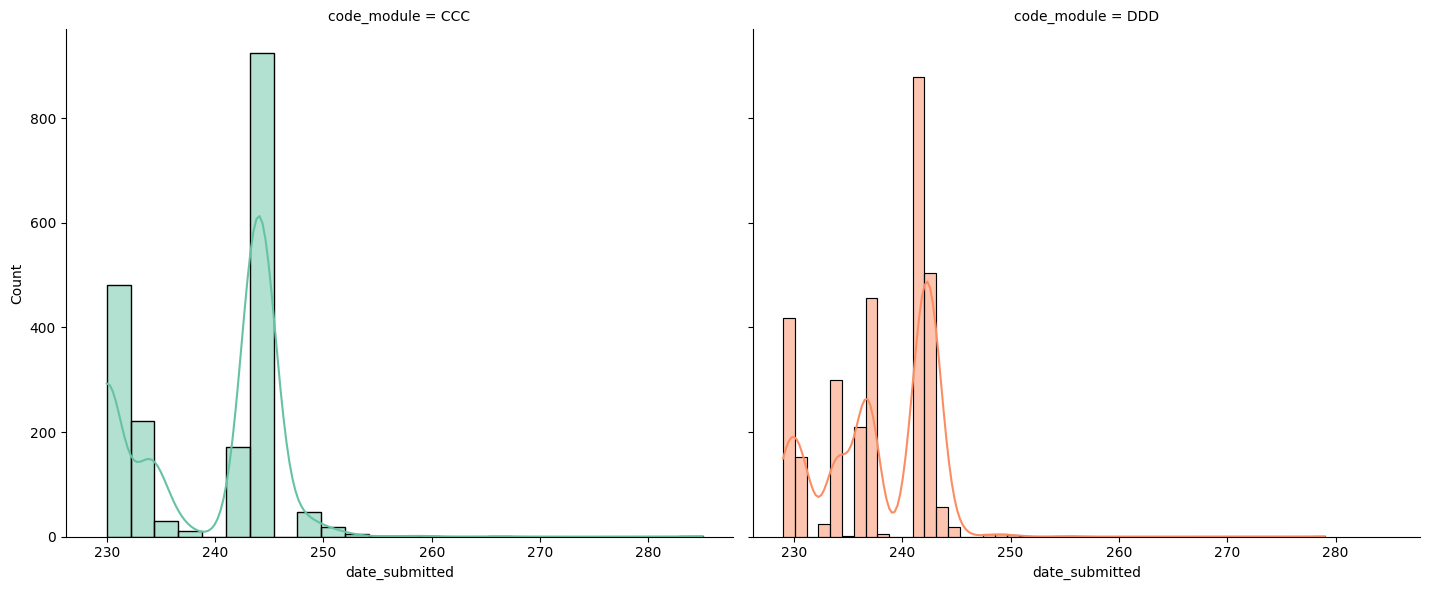

In [29]:
color = sns.color_palette("Set2")
g = sns.FacetGrid (data = all_exams, col = 'code_module', hue = 'code_module',
                   col_wrap = 2, height = 6, aspect = 1.2,
                   palette = color)
g.map(sns.histplot, 'date_submitted', kde=True)
sns.despine()

<span style="color:Tomato">**Из полученных графиков делаем выводы:**</span>

1. Распределения данных не относятся к нормальным, имеет несколько мод, а также есть выбросы, что в совокупности говорит нам о том, что в качестве меры центральной тенденции лучше не брать среднеарифметическое значение.
2. Остается два варианта медиана и мода. Рассматривая график срока сдачи экзамена CCC в качестве меры центральной тенденции можно выбрать и медиану и моду, но я выбираю моду, поскольку большинство значений собрано вокруг одного числа, и, хотя в районе 230 все-же есть значительное количество значений, с другого конца также есть значений, которые размыты и уходят за пределы значения 280(хоть их и не много). Также, на графике видно, что в районе одного значения существенное количество данных, поэтому в данном случае я выбираю моду.
3. А вот на графике с экзаменом DDD мы видим несколько мод, которые не так явно различаются между собой, как на экзамене CCC. Поэтому для данного экзамена в качестве среднего значения я выберу медиану, которая будет лучше отражать среднее значение в наших данных.

In [30]:
CCC_mode = sc.mode(all_exams.query('code_module == "CCC"').date_submitted)
DDD_median = np.median(all_exams.query('code_module == "DDD"').date_submitted)

In [31]:
print(f'Средний срок сдачи CCC экзамена равно {CCC_mode[0]},а средний срок сдачи DDD экзамена равен {round(DDD_median)}')

Средний срок сдачи CCC экзамена равно 244,а средний срок сдачи DDD экзамена равен 237


### <span style="color:SteelBlue">Ответ:</span>

Средний срок сдачи CCC экзамена равно <span style="color:SteelBlue">**244**</span>,а средний срок сдачи DDD экзамена равен <span style="color:SteelBlue">**237**</span>

## <span style="color:LightSlateGray">4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).</span>

#### <span style="color:DarkGreen">1. Для начала взглянем поближе на таблицу `studentRegistration`. </span>

Проверим пустые значения

In [32]:
studentRegistration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

In [33]:
check_nan = studentRegistration.query('date_unregistration.isna() == False')
check_nan.query('date_registration.isna() == True').shape

(39, 5)

Есть 39 строк, в которых отсутсвует дата регистрации студента, но дата отмены регистрации при этом есть. Если смотреть в разрезе всего датафрейма, то это не такое уж большое количество отсутствующих записей, поэтому скорее всего при записи данных произошла ошибка, поэтому эти данные удалять из дф не буду. 

Также проверим дф на ошибку записи где дата отмена регистрации была бы меньше, чем дата регистрации студента на курс:

In [34]:
studentRegistration.query('date_unregistration < date_registration')

,code_module,code_presentation,id_student,date_registration,date_unregistration


Таких студентов нет.

Возможно бд записывала студентов, которые зарегестрировались на курс, отменили регистрацию и снова зарегестрировались на тот же курс.

In [35]:
studentRegistration.duplicated(subset=('code_presentation', 'code_module', 'id_student')).value_counts()

False    32593
Name: count, dtype: int64

Такиих студентов тоже нет. 

Теперь проверим есть ли те студенты, которые зарегестрировались на один и тот же курс в разных семестрах.

In [36]:
studentRegistration.duplicated(subset=('code_module', 'id_student')).value_counts()

False    31284
True      1309
Name: count, dtype: int64

Для учета оттока полльзователей и количества самых популярных предметов эти дубли нам не понадобятся, поскольку один и тот-же студент регистрировался на один предмет. 

In [37]:
studentRegistration = studentRegistration.drop_duplicates(subset=('code_module', 'id_student'))

#### <span style="color:DarkGreen">2. Теперь детальнее рассмотрим колонку `date_registration` в которую внесены данные о дате регистрации студента в виде количества дней, измеренного от начала семестра.</span>

Проверим сколько людей зарегестрировалось после того, как курс начался.

In [38]:
punctual_person = studentRegistration.query('date_registration <= 0').date_registration.count()
unpunctual_person = studentRegistration.query('date_registration > 0').date_registration.count()

In [39]:
print(f'''Количество пунктуальных(зарегестрировавшихся на курс вовремя) студентов = {punctual_person},
а количество непунктуальных студентов = {unpunctual_person}. 
Процент пользователей зарегестрированных невовремя равен {round(unpunctual_person/punctual_person * 100, 3)}%''', sep = '\n')

Количество пунктуальных(зарегестрировавшихся на курс вовремя) студентов = 31038,
а количество непунктуальных студентов = 206. 
Процент пользователей зарегестрированных невовремя равен 0.664%


#### <span style="color:DarkGreen">3. Посмотрим детальнее на тех, кто зарегестрировался после начала семестра и проверим, могут ли они как-то повлиять на те метрики, которые мы должны найти в этом задании:</span>

In [40]:
unpunctual_person = studentRegistration.query('date_registration > 0') \
                                       .sort_values('date_registration', ascending = False)
unpunctual_person

,code_module,code_presentation,id_student,date_registration,date_unregistration
14178,DDD,2013B,596620,167.0,193.0
13528,DDD,2013B,472949,124.0,NaN
14612,DDD,2013J,305535,101.0,NaN
1154,BBB,2013B,442466,69.0,NaN
13514,DDD,2013B,467413,49.0,NaN
...,...,...,...,...,...
29519,FFF,2014J,685140,2.0,NaN
32149,GGG,2014J,646891,2.0,NaN
32080,GGG,2014J,642851,2.0,NaN
4515,BBB,2013J,613162,2.0,66.0


Проверю процент оттока людей, зарегестрировавшихся после того, как курс начался. 

In [41]:
unpunctual_person.query('date_unregistration.isna() == False').shape[0] / \
unpunctual_person.query('date_unregistration.isna() == True').shape[0] * 100

25.609756097560975

<span style="color:Tomato">**Таким образом мы видим:**</span>

1. В основном пользователи регистрируются на курсы вовремя, но есть и те, кто регистрируется после начала семестра. Это означает, что школа/платформа предоставляет такую возможность, и студенты могут сдавать экзамены, пропустив часть теоретического материала.
2. Процент зарегистрировавшихся после начала курса составляет всего лишь 0,664%, что не оказывает значительного влияния на общий отток студентов. Тем не менее, я решил также изучить процент оттока внутри самой группы и обнаружил, что он составляет 25%. Это значение также оказывает незначительное влияние на общую группу студентов. Поэтому, я принял решение оставить в выборке всех пользователей, чтобы проверить заданные метрики.

#### <span style="color:DarkGreen">4. Теперь перейдем к первой части задания. Для выявления 3х самых популярных предметов необходимо вспомнить, что предметом является столбец `code_module`</span>

<span style="color:Tomato">**ВАЖНО!**</span>
Затрагивая тему популярности предмета, можно рассматривать общее количество студентов, зарегистрировавшихся на этот предмет, а также только тех, кто не отменил свою регистрацию. Я считаю, что популярность определяется по спросу людей на данный предмет. Существует множество причин, по которым студенты могут изменить свое решение и отменить регистрацию на предмет, эти факторы не оказывают значительного влияния на общую популярность предмета. Поэтому при оценке популярности я учитываю всех студентов, независимо от того, отменили они свою регистрацию или нет.

In [42]:
popular_sub = studentRegistration.groupby('code_module', as_index = False).agg({'id_student':'count'})
popular_sub.sort_values('id_student', ascending = False)

,code_module,id_student
1,BBB,7692
5,FFF,7397
3,DDD,5848
2,CCC,4251
4,EEE,2859
6,GGG,2525
0,AAA,712


Посмотрим на популярность предметов в разрезе семестров:

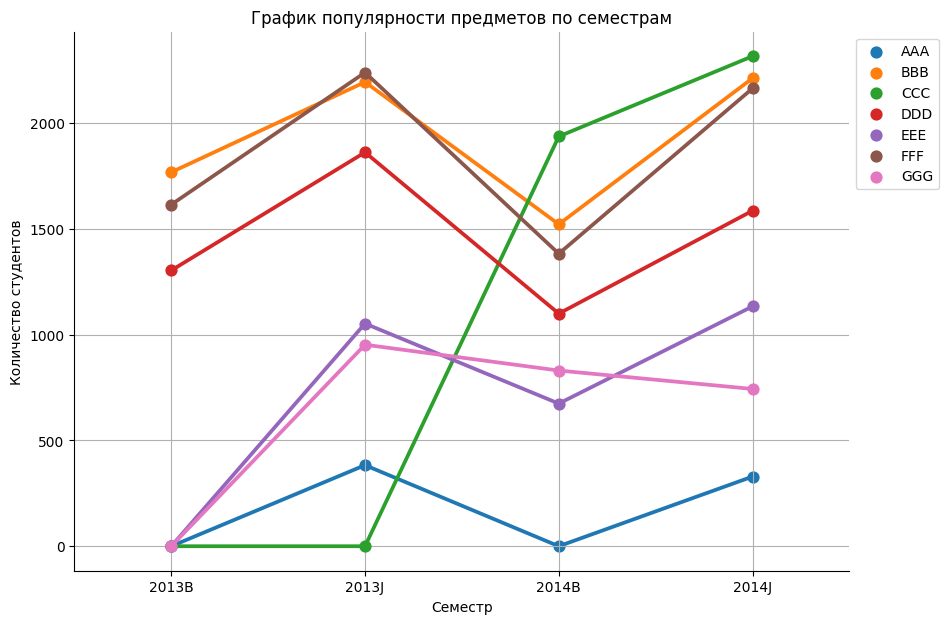

In [43]:
plt.figure(figsize = (10,7))
ax = sns.pointplot(data = studentRegistration, x = 'code_presentation', 
                   y = 'id_student', hue = 'code_module', estimator=len,
                   order = ['2013B', '2013J', '2014B', '2014J'])
ax.set_title('График популярности предметов по семестрам')
ax.set_xlabel('Семестр')
ax.set_ylabel('Количество студентов')
ax.legend(loc = "upper left", bbox_to_anchor = (1,1))
ax.grid()
sns.despine()

<span style="color:Tomato">**Отмечу следующие важные моменты:**</span>

1. Популярность предметов отображенная на этом графике обусловена скорее сезонностью, что также связано с моим предположением о том, что означают буква **B** (лето) и **J** (зима) в 1 задании.

2. Также важно заметить, что появившийся в 2014 году предмет обогнал по популярности все остальные предметы, а те 3 предмета, что появились только в конце 2013 года (EEE, GGG, AAA) в любом случае вне топ 3, поэтому для объективной оценки популярность предметов следует рассмотреть в разрезе по годам а не семестрам.

In [44]:
changed_student_Reg = studentRegistration.copy()
changed_student_Reg['code_presentation'] = changed_student_Reg.code_presentation.apply(lambda x: x[:4])
changed_student_Reg

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013,11391,-159.0,NaN
1,AAA,2013,28400,-53.0,NaN
2,AAA,2013,30268,-92.0,12.0
3,AAA,2013,31604,-52.0,NaN
4,AAA,2013,32885,-176.0,NaN
...,...,...,...,...,...
32588,GGG,2014,2640965,-4.0,NaN
32589,GGG,2014,2645731,-23.0,NaN
32590,GGG,2014,2648187,-129.0,NaN
32591,GGG,2014,2679821,-49.0,101.0


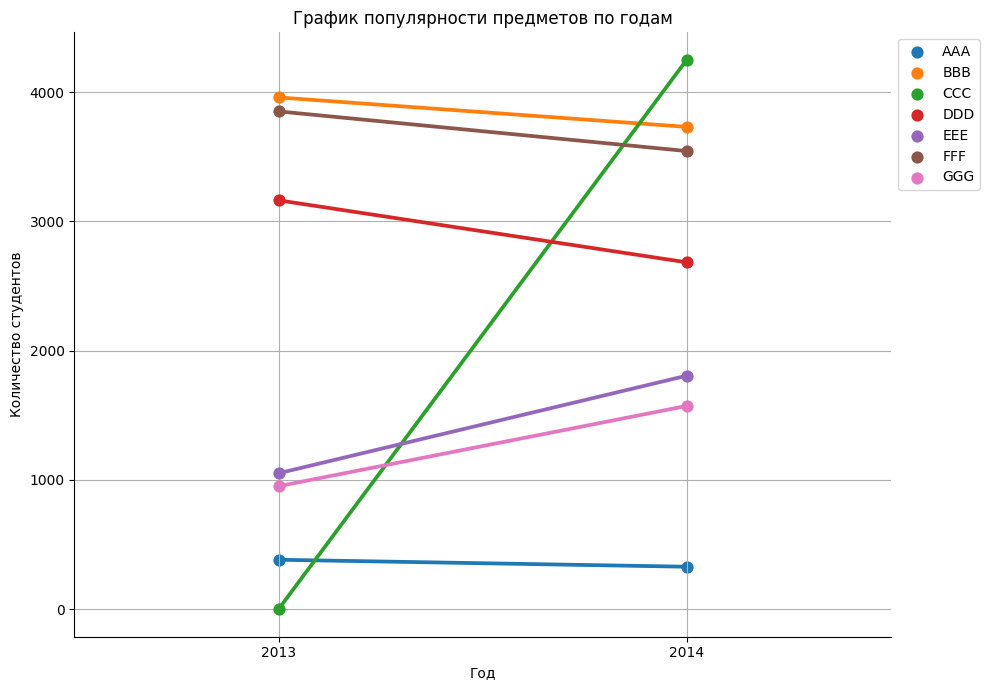

In [45]:
plt.figure(figsize = (10,7))
ax = sns.pointplot(data = changed_student_Reg, x = 'code_presentation', 
                   y = 'id_student', hue = 'code_module', estimator=len)
ax.set_title('График популярности предметов по годам')
ax.set_xlabel('Год')
ax.set_ylabel('Количество студентов')
ax.legend(loc = "upper left", bbox_to_anchor = (1,1))
ax.grid()
plt.tight_layout()
sns.despine()

<span style="color:Tomato">**Вывод:**</span>

1. Если брать сырые данные, то в топ 3 самых популярных предмета входят - <span style="color:Tomato">BBB, FFF, DDD</span>
2. Если же рассматривать популярность предметов внутри года, что будет более объективной оценкой, поскольку сравнение идет между предметами на одном промежутке времени, то самыми популярными предметами в 2013 году были <span style="color:Tomato">BBB, FFF, DDD</span>, а вот в 2014 году появился предмет CCC, который стал самым популярным и топ 3 в 2014 году топ изменился и стал таким: <span style="color:Tomato">CCC, BBB и FFF</span>

#### <span style="color:DarkGreen">5. Перейдем ко второй части задания и найдем топ 3 предмета с самым высоким оттоком.</span>

Для того, чтобы найти предметы с самым большим оттоком пользователей можно также использовать таблицу с годами обучения, поскольку в контексте **предмета** мы рассматриваем существующие предметы на каком-либо промежутке времени. Считать отток я буду не через количество учеников, которые отменили регистрацию, поскольку на какой-то предмет просто больше людей было зарегестрировано, а через коэффициент отттока - то есть через метрику **churn rate**, поэтому в каком семестре и году был этот предмет нам уже не важно. Формула **churn rate** для наших данных будет выглядеть следующим образом:

$$ CR = \frac{C_1 - C_2}{C_1}*100\% $$

- $C_1$ - студентов на предмете в начале года
- $C_2$ - студентов на предмете в конце года

В нашем случае верхняя часть уравнения известна - это те студенты, которые отменили регистрацию на курс

In [46]:
unreg_students = changed_student_Reg.query('date_unregistration.isna() == False') \
                   .groupby('code_module') \
                   .agg({'id_student':'count'})

In [47]:
all_students = changed_student_Reg.groupby('code_module') \
                   .agg({'id_student':'count'})

In [48]:
all_students['churn_rate'] = unreg_students / all_students * 100

In [49]:
all_students['churn_rate'] = all_students.churn_rate.apply(lambda x: f'{round(x, 2)}%')
all_students.reset_index().sort_values('churn_rate', ascending = False)

,code_module,id_student,churn_rate
2,CCC,4251,43.71%
3,DDD,5848,35.16%
5,FFF,7397,30.23%
1,BBB,7692,29.99%
4,EEE,2859,24.2%
0,AAA,712,16.29%
6,GGG,2525,11.37%


### <span style="color:SteelBlue">Ответ:</span>

1. Топ 3 самых популярных предмета в 2013 году: <span style="color:SteelBlue">**BBB, FFF и DDD**</span>, а в 2014 году: <span style="color:SteelBlue">**CCC, BBB и FFF.**</span>
2. Топ 3 предмета с самым большим оттоком стали <span style="color:SteelBlue">**CCC, DDD, FFF**.</span>

## <span style="color:LightSlateGray">5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.</span>
<span style="color:Tomato">завершаемость</span> = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

#### <span style="color:DarkGreen">1. Самую низкую завершаемость курса я уже находил во втором пункте, поэтому, чтобы выявить семестр с самой низкой завершаемостью курсов можно пойти тем-же путем, но в конце сгруппировать данные по курсу и посчитать внутри курса средний процент сдачи экзаменов:</span>

Снова соберем основные таблицы, которые нам понадобятся в дальнейшем

In [50]:
graduate_students = assessments.query('assessment_type == "Exam"') \
                               .merge(register_students, on = 'id_assessment') \
                               .query('score >= 40')

all_students = assessments.merge(register_students, on = 'id_assessment')

all_exams = all_students.query('assessment_type == "Exam"')

1. Сначала отберем только тех учеников, которые успешно сдали экзамен.

In [51]:
success_exams = graduate_students.groupby(['code_presentation', 'code_module'], as_index = False) \
                  .agg(students = ('id_assessment','count'))  \
                  .sort_values('students', ascending = False)
success_exams

,code_presentation,code_module,students
4,2014J,CCC,1019
1,2013J,DDD,878
5,2014J,DDD,842
2,2014B,CCC,664
0,2013B,DDD,504
3,2014B,DDD,485


2. Затем отберем всех учеников, кто был допущен до экзамена

In [52]:
grouped_all_exams = all_exams.groupby(['code_presentation', 'code_module'], as_index = False) \
                  .agg(students = ('id_assessment','count'))  \
                  .sort_values('students', ascending = False)
grouped_all_exams

,code_presentation,code_module,students
4,2014J,CCC,1168
1,2013J,DDD,967
5,2014J,DDD,950
2,2014B,CCC,747
0,2013B,DDD,602
3,2014B,DDD,524


3. Найдем процент завершаемости экзаменов по курсам

In [53]:
success_exams['peace_of_success'] = round(success_exams.students / grouped_all_exams.students * 100, 2)
success_exams = success_exams.sort_values('peace_of_success')
success_exams

,code_presentation,code_module,students,peace_of_success
0,2013B,DDD,504,83.72
4,2014J,CCC,1019,87.24
5,2014J,DDD,842,88.63
2,2014B,CCC,664,88.89
1,2013J,DDD,878,90.80
3,2014B,DDD,485,92.56


4. Ну и наконец произведем группировку по семестрам и найдем среднее значение завершаемости семестра в процентах:

In [54]:
completion = success_exams.groupby('code_presentation', as_index = False) \
                          .agg(completion_percent = ('peace_of_success', 'mean'))
completion['completion_percent'] = completion.completion_percent.apply(lambda x: f'{round(x, 1)}%')
completion

,code_presentation,completion_percent
0,2013B,83.7%
1,2013J,90.8%
2,2014B,90.7%
3,2014J,87.9%


<span style="color:Tomato">**Вывод:**</span>

Семестр с самой низкой завершаемостью курсов - <span style="color:Tomato">2013B</span>

#### <span style="color:DarkGreen">2. Перейдем ко второй части задания, где нужно найти курс с самой долгим средним сроком сдачи:</span>

Для начала необходимо определиться по какому критерию определять длительность срока сдачи курса. 

В качестве измерения длительности сдачи будем рассматривать время сдачи экзамена студента - то есть колонку `date_submitted` из таблицы `studentAssessment`.

При рассмотрении данных о длительности сдачи, необходимо учитывать, что в колонке есть факт перезачета теста студентом с прошлого семестра, которые могут повлиять на наши данные. Надо посмотреть как записываются данные в колонку `date_submitted` если факт перезачета есть:

In [55]:
assessments.merge(studentAssessment, on = 'id_assessment').query('is_banked > 0').head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
1641,AAA,2014J,1758,TMA,19.0,10.0,603861,-1,1,61.0
1685,AAA,2014J,1758,TMA,19.0,10.0,1970390,-1,1,78.0
1690,AAA,2014J,1758,TMA,19.0,10.0,2073016,-1,1,60.0
1693,AAA,2014J,1758,TMA,19.0,10.0,2139353,-1,1,65.0
1708,AAA,2014J,1758,TMA,19.0,10.0,2358969,-1,1,68.0


Рассмотрим случайно выбранного студента из предыдущего результата для сравнения с предыдущим семестром.

In [56]:
assessments.merge(studentAssessment, on = 'id_assessment').query('is_banked == 0 & id_student == 603861')

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
211,AAA,2013J,1752,TMA,19.0,10.0,603861,19,0,61.0
699,AAA,2013J,1753,TMA,54.0,20.0,603861,59,0,56.0
707,AAA,2013J,1754,TMA,117.0,20.0,603861,117,0,58.0
1209,AAA,2013J,1755,TMA,166.0,20.0,603861,174,0,69.0
1632,AAA,2013J,1756,TMA,215.0,30.0,603861,222,0,71.0


In [57]:
assessments.merge(studentAssessment, on = 'id_assessment').query('is_banked > 0 & id_student == 603861')

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
1641,AAA,2014J,1758,TMA,19.0,10.0,603861,-1,1,61.0
2184,AAA,2014J,1759,TMA,54.0,20.0,603861,-1,1,56.0
2585,AAA,2014J,1760,TMA,117.0,20.0,603861,-1,1,58.0
2599,AAA,2014J,1761,TMA,166.0,20.0,603861,-1,1,69.0
3065,AAA,2014J,1762,TMA,215.0,30.0,603861,-1,1,71.0


Теперь мы видим, что факт перезачета может существенно сказаться на наших данных, а значит, необходимо провести проверку на факт перезачета перед тем, как мы будем использовать данные при расчете среднего срока сдачи курсов. 

In [58]:
all_exams = assessments.merge(register_students, on = 'id_assessment') \
                       .query('assessment_type == "Exam"')
all_exams.query('is_banked > 0')

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score


<span style="color:Tomato">**Отлично!**</span>

Таких студентов нет, а значит экзамены студентам не перезасчитывали и мы можем спокойно рассматривать колонку `date_submitted`. 

Теперь принимаем решение - какую меру центральной тенденции использовать для наших данных.

In [59]:
all_exams.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
49968,CCC,2014B,24290,Exam,NaN,100.0,558914,230,0,32.0
49969,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0
49970,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0
49971,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0
49972,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0


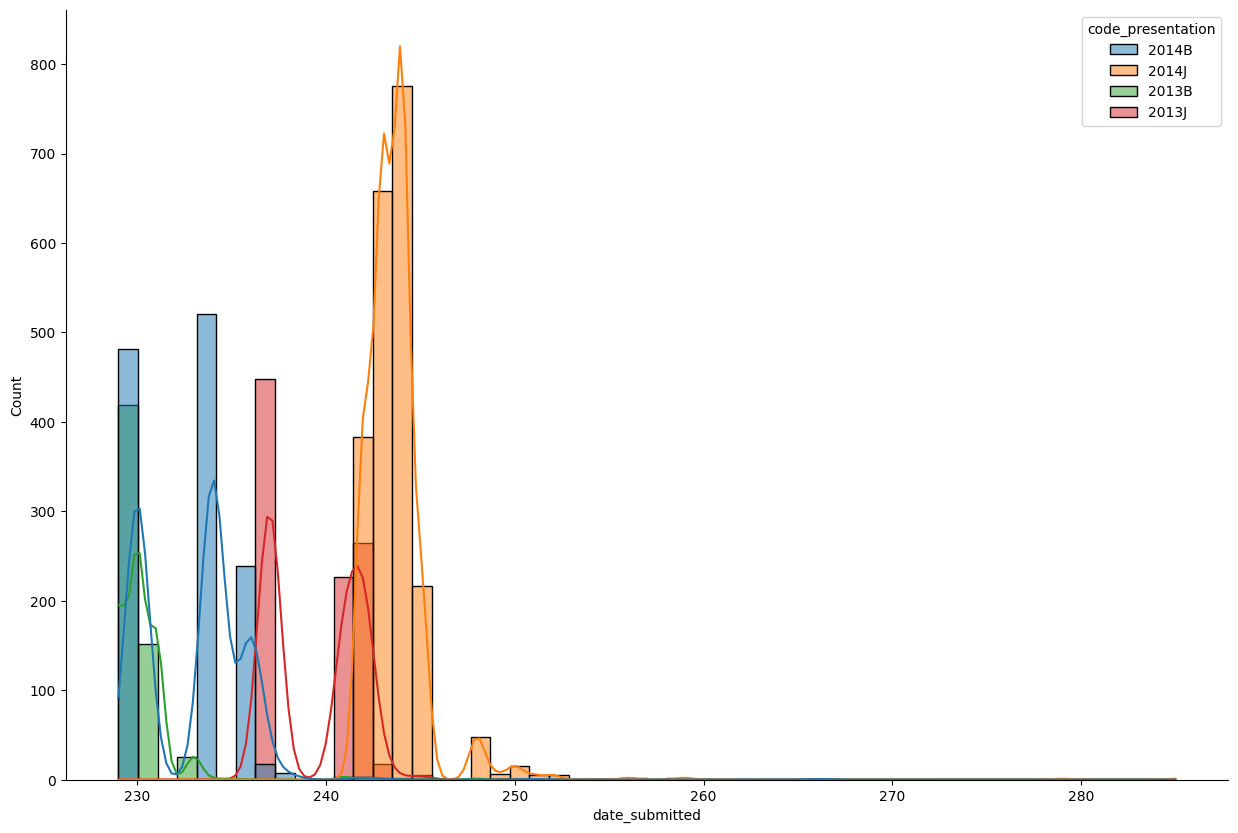

In [60]:
plt.figure(figsize = (15,10))
sns.histplot(data = all_exams, kde = True, x = 'date_submitted', hue = 'code_presentation')
sns.despine()

Благодаря нашему расспределению мы уже можем убедиться в том, что в среднем семестр с самой долгой средней сдачей курсов является 2014J. Но лучше убедиться также и на цифрах в этом. 

В качестве меры центральной тенденции лучше всего использовать медиану на таких данных.

In [61]:
avg_completion = all_exams.groupby('code_presentation', as_index = False) \
                          .agg(median = ('date_submitted', np.median)) \
                          .sort_values('median', ascending = False)
avg_completion

,code_presentation,median
3,2014J,244.0
1,2013J,241.0
2,2014B,234.0
0,2013B,230.0


### <span style="color:SteelBlue">Ответ:</span>

1. Семестр с самой низкой завершаемостью курсов - <span style="color:SteelBlue">**2013B**</span>. Его завершаемость равна <span style="color:SteelBlue">**83,7%**</span>.
2. Семестр с самой долгой средней сдачей курсов - <span style="color:SteelBlue">**2014J**</span>

## <span style="color:LightSlateGray">6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй адаптированные <span style="color:Tomato">RFM</span> - кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: <span style="color:Tomato">R</span> - среднее время сдачи одного экзамена, <span style="color:Tomato">F</span> - завершаемость курсов, <span style="color:Tomato">M</span> - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик <span style="color:Tomato">recency</span>, <span style="color:Tomato">frequency</span> и <span style="color:Tomato">monetary</span> для интерпретации этих кластеров.</span>

#### Предобработка данных для этого эатапа была проделана в предыдущих шагах. Поэтому начнем с того, что отберем средние значения по каждому из необходимых нам метрик, а именно:

- Среднее значение `date_submitted` по каждому студенту. Здесь подойдет и обычное среднее, поскольку студентов не так много, да и в целом у отдельного студента распределение дат будет похоже на нормальное. Поэтому берем `mean`
- Среднее значение `score` по каждому студенту.
- А вот значение завершаемости, которое рассчитывается <span style="color:Tomato">кол-во успешных экзаменов / кол-во всех попыток сдать экзамен</span> буду считать через количество уникальных тестов в знаменателе - `id_assessment` и количество сданных тестов в числителе, где `score >= 40`

#### <span style="color:DarkGreen">1. Итак, займемся этими пунктами по порядку. Сразу сделаем таблицу со средними значениями по `date_submitted` и `score`, а также посчитаем количество всех попыток сдать экзамен через `nunique` у колонки `id_assessment`</span>

In [62]:
RFM = all_exams.groupby('id_student', as_index = False) \
               .agg(avg_days_to_submit = ('date_submitted', 'mean'),
                    avg_score = ('score', 'mean'),
                    tries_qty = ('id_assessment', 'nunique')
                   )
RFM

,id_student,avg_days_to_submit,avg_score,tries_qty
0,23698,243.0,80.0,1
1,24213,236.0,58.0,1
2,27116,243.0,96.0,1
3,28046,237.0,40.0,1
4,28787,243.0,44.0,1
...,...,...,...,...
4627,2694886,236.0,69.0,1
4628,2694933,230.0,73.0,1
4629,2695608,237.0,73.0,1
4630,2697181,230.0,80.0,1


#### <span style="color:DarkGreen">2. Теперь создадим таблицу, в которой мы будем группировать по `id_student` и считать количество успешных сдач экзамена</span>

In [63]:
passed_exams = all_exams.query('score >= 40') \
                        .groupby('id_student', as_index = False) \
                        .agg(success = ('score', 'count'))

#### <span style="color:DarkGreen">3. Объединяем две наши таблицы через left merge и присваиваем отсутствующиим оценкам значение 0.</span>

In [64]:
RFM = RFM.merge(passed_exams, on = 'id_student', how = 'left').fillna(0)

In [65]:
RFM.head()

,id_student,avg_days_to_submit,avg_score,tries_qty,success
0,23698,243.0,80.0,1,1.0
1,24213,236.0,58.0,1,1.0
2,27116,243.0,96.0,1,1.0
3,28046,237.0,40.0,1,1.0
4,28787,243.0,44.0,1,1.0


<span style="color:Tomato">**В итоге:**</span>

Мы получили таблицу, в которой колонка `tries_qty` означает количество попыток студента сдать экзамен, а колонка `success` показывает успешное количество сданных экзаменов для этого студента. И теперь, чтобы найти среднюю завершаемость курса для студента необходимо просто разделить `success` на `tries_qty`

In [66]:
RFM['avg_completed'] = RFM.success/RFM.tries_qty

Избавимся от лишних столбцов в нашей таблице:

In [67]:
RFM = RFM.drop(columns = ['tries_qty', 'success'])
RFM.head()

,id_student,avg_days_to_submit,avg_score,avg_completed
0,23698,243.0,80.0,1.0
1,24213,236.0,58.0,1.0
2,27116,243.0,96.0,1.0
3,28046,237.0,40.0,1.0
4,28787,243.0,44.0,1.0


#### <span style="color:DarkGreen">4. Теперь необходимо принять решение на какие границы мы будем разбивать наши данные, для этого посмотрим на наши данные поближе:</span>

1. Сначала разберусь с оценками `avg_score` и разделю их на сегменты. Для удобства анализа, я буду разбивать данные оценок на сегменты, используя пятибальную систему оценивания. Для этого я применю метод квантилей. Однако, есть одно важное условие: мы знаем, что оценка "2" соответствует результату "неуд", как и результат менее 40 баллов, поэтому при вычислении квантилей для остальных оценок, я буду учитывать это условие. Таким образом, сначала определю квантиль для оценки "2", а затем разделю остальные оценки на квантили. Используя этот подход, можно разбить данные оценок на понятные сегменты и проанализировать их более детально. Также по понятным причинам оценки 1 не будет:

In [68]:
quintile_for_2_score = pd.Series(40.0, index = [0.2], name = 'avg_score')
quintile_for_2_score

0.2    40.0
Name: avg_score, dtype: float64

In [69]:
quintiles_for_score = RFM['avg_score'].quantile([.4, .75])
quintiles_for_score = pd.concat([quintiles_for_score, quintile_for_2_score]).sort_index().to_dict()
quintiles_for_score

{0.2: 40.0, 0.4: 60.0, 0.75: 82.0}

In [70]:
def M_score(x):
    if x < quintiles_for_score[.2]:
        return 2
    elif x < quintiles_for_score[.4]:
        return 3
    elif x < quintiles_for_score[.75]:
        return 4
    else:
        return 5

In [71]:
RFM['M'] = RFM.avg_score.apply(lambda x: M_score(x))

2. Теперь разберем среднее время сдачи экзамена - `avg_days_to_submit`. Колонка `date` в таблице `assessments` означает дедлайн экзаменов, но при этом для того, чтобы судить о среднем значении дедлайна для экзаменов этих данных нам мало, поскольку большинство значений отсутствует а сами даты по одному экзамену сильно плавают, поэтому рассчитывать сегменты по этой метрике я буду вручную.

In [72]:
assessments.query('assessment_type == "Exam"').query('code_module == "CCC" | code_module == "DDD"')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0
87,DDD,2013B,25340,Exam,240.0,100.0
94,DDD,2013J,25354,Exam,261.0,100.0
101,DDD,2014B,25361,Exam,241.0,100.0
108,DDD,2014J,25368,Exam,NaN,100.0


Для того чтобы разбить на групыы более качественно - посмотрим какие числа принимают наши значения на графике:

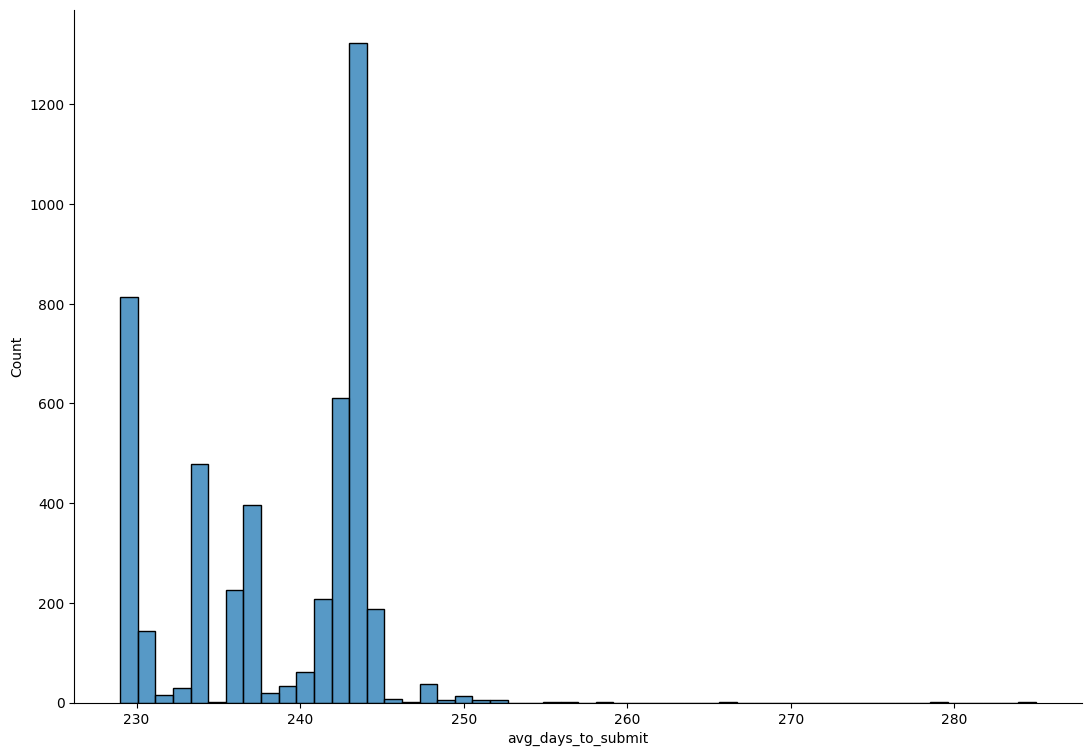

In [73]:
plt.figure(figsize = (13,9))
sns.histplot(RFM.avg_days_to_submit)
sns.despine()

In [74]:
RFM.avg_days_to_submit.min()

229.0

На графике видно, что большинство значений собрано в одной области - вокруг значения 243(что скорее всего говорит как раз о средней сдаче или дедлайне, ведь студенты чаще всего сдают большими группами экзамен), а также есть большое количество данных на отметке 229, что может свидетельствовать об отличниках или преуспевающих студентах. Поэтому сегментацию данной метрики я буду проводить исходя из следущих соображений:
- Ранняя сдача экзамена - [229, 234]
- Своевременная сдача экзамена - [235, 245]
- Сдача экзамена с задержкой - [246, ]

In [75]:
quintile_for_days = pd.Series([234.0, 245.0],  index = [1, 2], name = 'avg_days_to_submit').to_dict()
quintile_for_days

{1: 234.0, 2: 245.0}

In [76]:
def R_score(x):
    if x <= quintile_for_days[1]:
        return 1
    elif x <= quintile_for_days[2]:
        return 2
    else:
        return 3

In [77]:
RFM['R'] = RFM.avg_days_to_submit.apply(lambda x: R_score(x))

3. Осталось последнее - разобрать сегменты для метрики F. Но, поскольку значений у нас там не много, то и вопрос с сегментацией становится не таким трудным:

In [78]:
completed_rate = RFM.avg_completed.unique().tolist()
completed_rate

[1.0, 0.0, 0.5]

In [79]:
def F_score(x):
    if x == completed_rate[1]:
        return 1
    elif x == completed_rate[2]:
        return 2
    else:
        return 3

In [80]:
RFM['F'] = RFM.avg_completed.apply(lambda x: F_score(x))

Теперь соберем все сегменты в единый `RFM_score`

In [81]:
RFM['RFM_Score'] = RFM['R'].map(str) + RFM['F'].map(str) + RFM['M'].map(str)
RFM.head()

,id_student,avg_days_to_submit,avg_score,avg_completed,M,R,F,RFM_Score
0,23698,243.0,80.0,1.0,4,2,3,234
1,24213,236.0,58.0,1.0,3,2,3,233
2,27116,243.0,96.0,1.0,5,2,3,235
3,28046,237.0,40.0,1.0,3,2,3,233
4,28787,243.0,44.0,1.0,3,2,3,233


#### <span style="color:DarkGreen">5. Пришло время разделять!</span>

- <span style="color:SteelBlue">Дети маминой подруги</span> - отличники, которые сдают все быстро и при этом закрывают все предметы только на отлично
- <span style="color:SteelBlue">Обычные отличники</span> - отличники, которые сдают на 5, но при этом не торопятся и сдают в спокойном темпе
- <span style="color:SteelBlue">Хорошист на грани отличника</span> - те, кто сдает быстро и при этом сдает все экзамены, но из-за спешки не получает пятерку
- <span style="color:SteelBlue">Хорошист</span> - обычный студент
- <span style="color:SteelBlue">Непризнанные гении</span> - студент, который завершил один курс, но завалил экзамен на другом курсе
- <span style="color:SteelBlue">Медианные старожилы</span> - троечники
- <span style="color:SteelBlue">Торопыги</span> - студенты, сдавшие на двойку все предметы из-за своей спешки
- <span style="color:SteelBlue">Типичный Я</span> - двоечники

In [82]:
segt_map = {
    r'135': 'Дети маминой подруги',
    r'[2-3][2-3]5': 'Обычные отличники',
    r'134' : 'Хорошист на грани отличника',
    r'[2-3][2-3]4' : 'Хорошист',
    r'[1-3]2[2-5]' : 'Непризнанные гении',
    r'[1-3][1-3]3' : 'Медианные старожилы',
    r'112' : 'Торопыги',
    r'[2-3]12' : 'Типичный Я'
}

RFM['Segment'] = RFM['R'].map(str) + RFM['F'].map(str) + RFM['M'].map(str) 
RFM['Segment'] = RFM['Segment'].replace(segt_map, regex=True)
RFM.head()

,id_student,avg_days_to_submit,avg_score,avg_completed,M,R,F,RFM_Score,Segment
0,23698,243.0,80.0,1.0,4,2,3,234,Хорошист
1,24213,236.0,58.0,1.0,3,2,3,233,Медианные старожилы
2,27116,243.0,96.0,1.0,5,2,3,235,Обычные отличники
3,28046,237.0,40.0,1.0,3,2,3,233,Медианные старожилы
4,28787,243.0,44.0,1.0,3,2,3,233,Медианные старожилы


Посмотрим, всех ли мы назвали?

In [83]:
RFM['Segment'].unique()

array(['Хорошист', 'Медианные старожилы', 'Обычные отличники',
       'Дети маминой подруги', 'Хорошист на грани отличника',
       'Типичный Я', 'Торопыги', 'Непризнанные гении'], dtype=object)

#### <span style="color:DarkGreen">6. Осталось собрать наших ребятишек в другой датафрейм и посмотреть насколько хорошо школа/платформа справляется с выпуском грамотных специалистов</span>

In [84]:
df = RFM.groupby('Segment', as_index = False) \
        .agg(students_count = ('id_student', 'count')) \
        .sort_values('students_count', ascending = False)

In [85]:
df['percents'] = round(df.students_count/df.students_count.sum() * 100, 2)

Сравним датафрейм с начальным и узнаем нет ли у нас переплетений в данных?

In [86]:
df.students_count.sum() == len(RFM)

True

Все ок!

In [87]:
df

,Segment,students_count,percents
1,Медианные старожилы,1243,26.84
6,Хорошист,1139,24.59
3,Обычные отличники,817,17.64
7,Хорошист на грани отличника,506,10.92
0,Дети маминой подруги,364,7.86
4,Типичный Я,356,7.69
5,Торопыги,179,3.86
2,Непризнанные гении,28,0.60


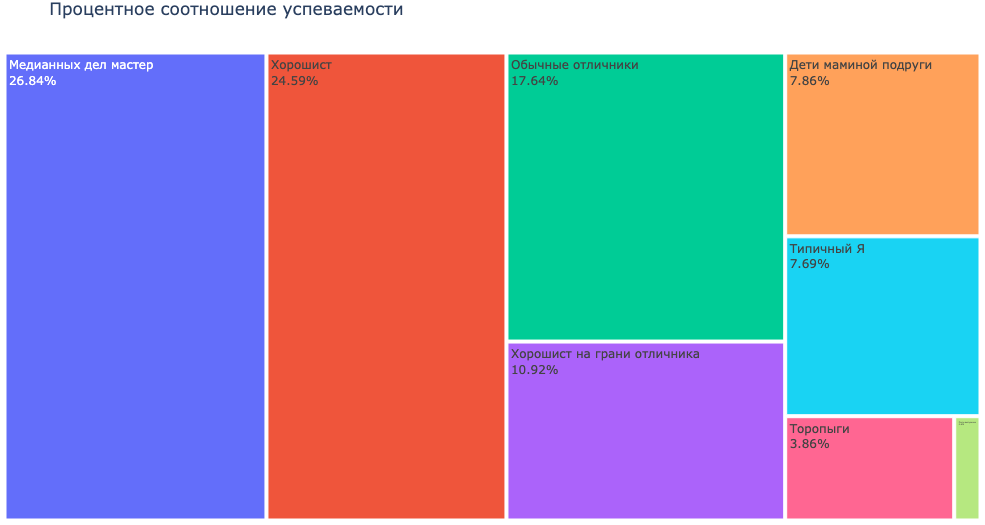

In [88]:
fig = go.Figure(go.Treemap(labels = df['Segment'], 
                           parents = ['', '', '', '', '', '', '', ''],
                           values = df['percents'],
                           text = df['percents'].astype(str) + '%',
            hovertemplate = '''Segment: %{label}<br>percents: %{text}<extra></extra>'''))

fig.update_layout(title='Процентное соотношение успеваемости',
                  margin=dict(t=30, l=0, r=0, b=0))

Image("newplot.png")

Для ясности продублирую названия студентов здесь:
- <span style="color:SteelBlue">Дети маминой подруги</span> - отличники, которые сдают все быстро и при этом закрывают все предметы только на отлично
- <span style="color:SteelBlue">Обычные отличники</span> - отличники, которые сдают на 5, но при этом не торопятся и сдают в спокойном темпе
- <span style="color:SteelBlue">Хорошист на грани отличника</span> - те, кто сдает быстро и при этом сдает все экзамены, но из-за спешки не получает пятерку
- <span style="color:SteelBlue">Хорошист</span> - обычный студент
- <span style="color:SteelBlue">Непризнанные гении</span> - студент, который завершил один курс, но завалил экзамен на другом курсе
- <span style="color:SteelBlue">Медианные старожилы</span> - троечники
- <span style="color:SteelBlue">Торопыги</span> - студенты, сдавшие на двойку все предметы из-за своей спешки
- <span style="color:SteelBlue">Типичный Я</span> - двоечники

### <span style="color:SteelBlue">Заключение:</span>

1. В результате сегментации я обнаружил, что в распределении большая часть студентов успешно сдает экзамен. 
2. Большинство студентов сдают экзамен на тройки(Медианные старожилы) и четверки
3. Процент людей не сдавших экзамен около 10%
4. А дети маминой подруги и тут преуспели, их на 0.17% больше, чем двоечников.